In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('../data/beetle_original.csv', 'r') as f:
    header = f.readline().strip().split(',')
    src = []
    for line in f:
        src.append(list(map(float, line.strip().split(','))))
src = np.array(src)
print(header)
print(src)

['gas concentration', 'number of beetles', 'number of deaths']
[[ 1.6907 59.      6.    ]
 [ 1.7242 60.     13.    ]
 [ 1.7552 62.     18.    ]
 [ 1.7842 56.     28.    ]
 [ 1.8113 63.     52.    ]
 [ 1.8369 59.     53.    ]
 [ 1.861  62.     61.    ]
 [ 1.8839 60.     60.    ]]


In [3]:
y = src[:,2]
x = src[:,0][np.newaxis,:]
x = np.concatenate([np.ones(src.shape[0])[np.newaxis,:], x], 0)
print(x)

[[1.     1.     1.     1.     1.     1.     1.     1.    ]
 [1.6907 1.7242 1.7552 1.7842 1.8113 1.8369 1.861  1.8839]]


# Logistic regression (1変数)

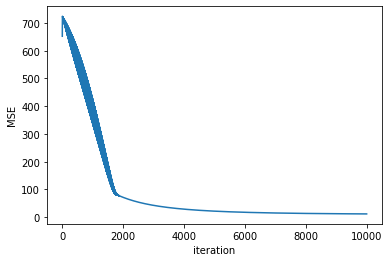

In [4]:
def err(w):
    pred = calc_freq(w)
    return (np.square(y - pred)).mean()

def calc_prob(x, w):
    z = w.dot(x)
    p = 1/(1+np.exp(-z))
    return p
    
def calc_freq(w):
    p = calc_prob(x, w)
    estimated_freq = src[:,1]*p
    return estimated_freq

def update(w):
    delta = np.array([0., 0.])
    eita = 0.005
    estimated_freq = calc_freq(w)
    delta[0] = (y-estimated_freq).sum()
    delta[1] = ((y-estimated_freq)*x[1]).sum()
    w += eita*delta
    return w
w = np.array([1., 1.])
err_ = []
for i in range(10000):
    w = update(w)
    err_.append(err(w))
plt.figure()
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.plot(err_)


Text(0, 0.5, 'probability of death')

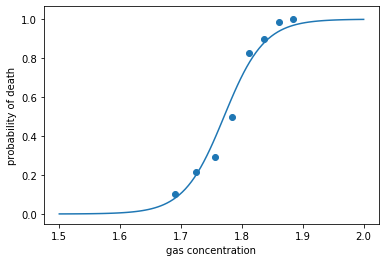

In [5]:
X = np.linspace(1.5,2., 100).reshape(1,100)
X = np.concatenate([np.ones(X.shape[1]).reshape(1,100), X], axis=0)
plt.figure()
plt.plot(X[1], calc_prob(X,w))
plt.scatter(x[1], src[:,2]/src[:,1])
plt.xlabel(header[0])
plt.ylabel('probability of death')

# 2変数

In [6]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('../data/titanic_data.csv')
print(df)

     PassengerId  Survived  Pclass   Age     Fare  Sex
0              1         0       3  22.0   7.2500    0
1              2         1       1  38.0  71.2833    1
2              3         1       3  26.0   7.9250    1
3              4         1       1  35.0  53.1000    1
4              5         0       3  35.0   8.0500    0
..           ...       ...     ...   ...      ...  ...
886          887         0       2  27.0  13.0000    0
887          888         1       1  19.0  30.0000    1
888          889         0       3   NaN  23.4500    1
889          890         1       1  26.0  30.0000    0
890          891         0       3  32.0   7.7500    0

[891 rows x 6 columns]


## 事前分析

/Users/isokawakoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/isokawakoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


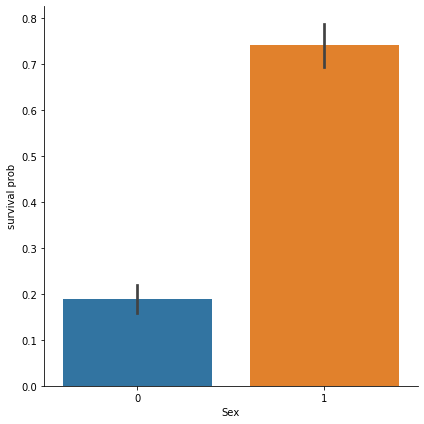

In [7]:
s_s = sns.factorplot(x="Sex",y="Survived", data=df, kind="bar", size = 6 )
s_s = s_s.set_ylabels("survival prob")
plt.show()

# 女性の生存率が高い

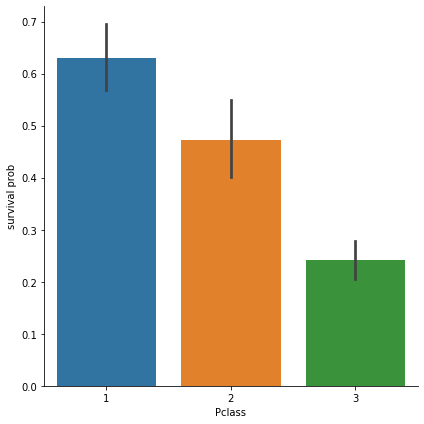

In [8]:
c_s = sns.factorplot(x="Pclass",y="Survived", data=df, kind="bar", size = 6 )
c_s = c_s.set_ylabels("survival prob")
plt.show()

#1級，2級，3級の順で生存率が高い

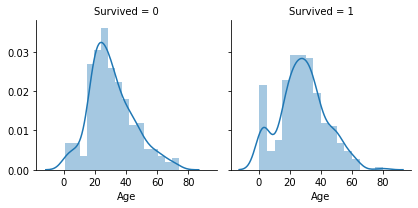

In [9]:
Fg = sns.FacetGrid(df, col='Survived')
Fg = Fg.map(sns.distplot, "Age")

#子供の生存率が高い, 死亡者は20代付近が多い

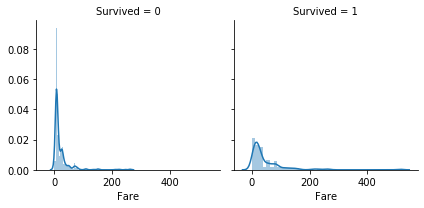

In [10]:
Fg = sns.FacetGrid(df, col='Survived')
Fg = Fg.map(sns.distplot, "Fare")

#死亡者の内訳として運賃が低い人が多い

## 複数の組み合せでLogistic regression
いずれも5-fold cross validationで評価

In [215]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df.loc[:, ['Sex', 'Pclass']]
res = df['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('Sex+Pclass: {}'.format((1-scores).mean()))

df2 = df.loc[:,['Survived', 'Sex', 'Age']]
df2 = df2.dropna(how='any')
logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df2.loc[:, ['Sex', 'Age']]
res = df2['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('Sex+Age: {}'.format((1-scores).mean()))

df2 = df.loc[:,['Survived', 'Sex', 'Fare']]
df2 = df2.dropna(how='any')
logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df2.loc[:, ['Sex', 'Fare']]
res = df2['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('Sex+Fare: {}'.format((1-scores).mean()))

df2 = df.loc[:,['Survived', 'Age', "Pclass"]]
df2 = df2.dropna(how='any')
logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df2.loc[:, ['Age', 'Pclass']]
res = df2['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('Pclass+Age: {}'.format((1-scores).mean()))

df2 = df.loc[:,['Survived', 'Fare', "Pclass"]]
df2 = df2.dropna(how='any')
logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df2.loc[:, ['Fare', 'Pclass']]
res = df2['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('Pclass+Fare: {}'.format((1-scores).mean()))

df2 = df.loc[:,['Survived', 'Age', "Fare"]]
df2 = df2.dropna(how='any')
logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df2.loc[:, ['Age', 'Fare']]
res = df2['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('Age+Fare: {}'.format((1-scores).mean()))

df2 = df.loc[:,['Survived', 'Age', "Pclass", 'Sex','Fare']]
df2 = df2.dropna(how='any')
logi = linear_model.LogisticRegression(C=0.1, max_iter=1000 ,penalty='l2')
explanatory = df2.loc[:, ['Age', 'Pclass','Sex']]
res = df2['Survived']
scores = cross_val_score(logi, explanatory, res, cv=5)
print('All: {}'.format((1-scores).mean()))


Sex+Pclass: 0.21328497507081207
Sex+Age: 0.2198660494435142
Sex+Fare: 0.2188840504619675
Pclass+Age: 0.32350044321875304
Pclass+Fare: 0.31744082088469805
Age+Fare: 0.3529203191175022
All: 0.20586033684625232


結果：
>Ageを使うと予測精度向上．  
>Age + Fare が良さげ